Importing the packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns   
import os 
import openpyxl  
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import folium
from folium.plugins import MarkerCluster

Loading the dataset

In [2]:
F1 = pd.read_excel("/Users/angelocapasso/Desktop/F1 Analysis/F1.xlsx", sheet_name = None)
sheet_names = list(F1.keys())
sheets = ['sprint_results', 'results', 'qualifying', 'pitstops', 'driverstandings', 'constructors_results', 'constructors_standing']

### 1) Data Preprocessing

Following, joins between table are made to connect the IDs with their names

In [3]:
F1['races'] = F1['races'].merge(
    F1['circuit'][['circuitId','circuit_name', 'circuit_country']], 
    on='circuitId', 
    how='left'
)
F1['races'] = F1['races'].drop('circuitId', axis=1)

Iterative joins using constructorId, driverId, raceId, statusId

In [4]:
for i in sheets:
    if 'driverId' in F1[i].columns:
        F1[i] = F1[i].merge(
        F1['drivers'][['driverId','surname', 'driver_nationality']], 
        on='driverId', 
        how='left'
        )
        F1[i] = F1[i].drop('driverId', axis = 1)


for i in sheets:
    if 'constructorId' in F1[i].columns:
        F1[i] = F1[i].merge(
        F1['constructors_name'][['constructorId', 'cons_nationality', 'constructor_name']], 
        on='constructorId', 
        how='left'
        )
        F1[i] = F1[i].drop('constructorId', axis = 1)


for i in sheets:
    if 'raceId' in F1[i].columns:
        F1[i] = F1[i].merge(
        F1['races'][['raceId', 'race_name', 'circuit_name', 'year']], 
        on='raceId', 
        how='left'
        )
        F1[i] = F1[i].drop('raceId', axis = 1) 
     

for i in sheets:
    if 'statusId' in F1[i].columns:
        F1[i] = F1[i].merge(
        F1['status'][['statusId', 'status']], 
        on='statusId', 
        how='left'
        )
        F1[i] = F1[i].drop('statusId', axis = 1) 

In [5]:
freq_driver_nationality = F1['drivers']['driver_nationality'].value_counts().reset_index()
freq_driver_nationality.columns = ['driver_nationality', 'Frequency']

# Creazione di un barplot con le frequenze ordinate in modo decrescente
fig = px.bar(freq_driver_nationality, x='driver_nationality', y='Frequency', 
             title="Driver Nationality",
             labels={'Frequency': 'Occurrency', 'Category': 'Nationality'},
             category_orders={'Category': freq_driver_nationality['driver_nationality'].tolist()})


fig.show()

In [6]:
circuit = pd.read_csv(r'/Users/angelocapasso/Desktop/F1 Analysis/circuits.csv')
F1['circuit'][['latitude','longitude','altitude']] = circuit[['lat','lng','alt']].astype(float)
F1['circuit'] = F1['circuit'].drop(['lat','lng','alt'], axis = 1)

In [7]:
m = folium.Map(location=[0, 0], zoom_start=2)

marker_cluster = MarkerCluster().add_to(m)

for _, row in F1['circuit'].iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"{row['location']}",
        tooltip=row['location']
    ).add_to(marker_cluster)

m.save("F1_Circuits_Map.html")
m

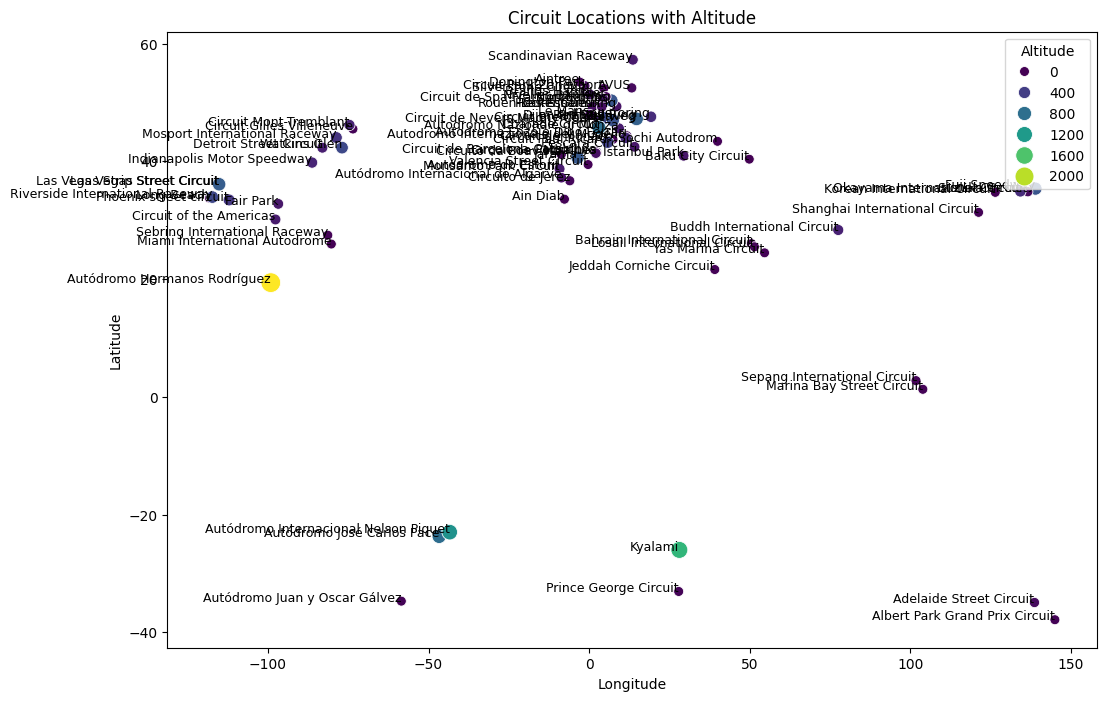

In [8]:
plt.figure(figsize=(12, 8))

# Creare lo scatter plot con Seaborn
circ_plot = sns.scatterplot(
    data=F1['circuit'], 
    x='longitude', 
    y='latitude', 
    hue='altitude',  # Colorare i punti in base all'altitudine
    palette='viridis',  # Scegli una palette di colori
    size='altitude',  # Facoltativo: dimensiona i punti in base all'altitudine
    sizes=(50, 200),  # Dimensione minima e massima dei punti
    legend='brief'
)

# Aggiungere le etichette per ogni punto
for i in range(F1['circuit'].shape[0]):
    circ_plot.text(
        F1['circuit']['longitude'][i], 
        F1['circuit']['latitude'][i], 
        F1['circuit']['circuit_name'][i], 
        fontsize=9, 
        ha='right'
    )

# Aggiungere un titolo e mostrare il grafico
plt.title("Circuit Locations with Altitude")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Altitude", loc='upper right')
plt.show()

In [9]:
stop_hist = px.bar(F1['pitstops'], x='status', title='Pitstops distribution')
lap_hist = px.histogram(F1['pitstops'], x='lap', title='Lap distribution')


stop_lap = make_subplots(rows=1, cols=2, subplot_titles=('Pitstops distribution', 'Lap distribution'))

for trace in stop_hist['data']:
    stop_lap.add_trace(trace, row=1, col=1)

for trace in lap_hist['data']:
    stop_lap.add_trace(trace, row=1, col=2)

# Aggiornare il layout del subplot
stop_lap.update_layout(title_text="Stops vs Laps", showlegend=False)

# Mostrare il grafico
stop_lap.show()

In [10]:
flop5_pitstops_desc = F1['pitstops'][
    F1['pitstops']['status'] == 'Finished'   
].sort_values(by='milliseconds', ascending=False).head(5)

flop5desc_plot = px.bar(
    flop5_pitstops_desc,                     
    x='surname',                 
    y='milliseconds',            
    title='Flop 5 Pistops',
    labels={'milliseconds': 'Time (milliseconds)', 'surname': 'Driver'},
    color='surname'              
)

top5_pitstops = F1['pitstops'][
    F1['pitstops']['status'] == 'Finished'   
].sort_values(by='milliseconds', ascending=True).head(5)

top5desc_plot = px.bar(
    top5_pitstops,                     
    x='surname',                 
    y='milliseconds',            
    title='Top 5 Pistops',
    labels={'milliseconds': 'Time (milliseconds)', 'surname': 'Driver'},
    color='surname'              
)

subplot_pitstops = make_subplots(rows=1, cols=2, subplot_titles=('Flop 5 Pitstops', 'Top 5 Pitstops'))

for trace in flop5desc_plot['data']:
    subplot_pitstops.add_trace(trace, row=1, col=1)

for trace in top5desc_plot['data']:
    subplot_pitstops.add_trace(trace, row=1, col=2)

subplot_pitstops.update_layout(
    title_text='Flop 5 vs Top 5 Pitstops',
    showlegend=False)

subplot_pitstops.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

